In [6]:
import numpy as np
from numpy.linalg import multi_dot
from numpy.linalg import qr
import numpy.linalg as npla
import scipy as sp
from scipy.linalg import block_diag, logm, eigvals
from multiprocessing import Pool
from functools import partial
import multiprocessing as mp
from multiprocessing import set_start_method
from multiprocessing import get_context
import matplotlib.pyplot as plt
import time
from scipy.linalg import lu
'''
All the matrix construction functions are defined in this file, they include

TAMatrix
TBMatrix
TAReplace
TBReplace

All functions take arguments (sin,cos)
They are all 2x2 np.arrays
'''
from matrix_constructions import *

In [7]:
theta = np.pi/4
sin = np.sin(theta)
cos = np.cos(theta)

In [8]:
#This function constructs full strips with width = strip_width
def FullStrip(sin,cos,strip_width,probability_cutoff): #np.array 2strip_width x 2strip_width
    
        #we construct TAS for TA type strips and multiply by TB type strips
        #this means our length is really 2x our strip_length followig the convention of CC
        #probability cutoff is first introduced here to replace specific nodes in both types of strips
        
        def TAS(sin,cos,strip_width,probability_cutoff):
            
            TAProbabilities = np.random.random_sample(strip_width)
            
            Tslist = [ 
                TAMatrix(sin,cos) if i < probability_cutoff 
                else TAReplace(sin,cos) for i in TAProbabilities
            ]
            
            return block_diag(*Tslist)

        
        def TBS(sin,cos,strip_width,probability_cutoff): 
            
            TBProbabilities = np.random.random_sample(strip_width-1)
            
            Tslist = [ 
                TBMatrix(sin,cos)if i < probability_cutoff
                else TBReplace(sin,cos) for i in TBProbabilities
            ]
            
            extra = TBMatrix(sin,cos)
            temp_mat = block_diag(extra[1,1],*Tslist,extra[0,0])    
            temp_mat[0,(2*strip_width)-1] = extra[1,0]
            temp_mat[(2*strip_width)-1,0] = extra[0,1]
            return temp_mat
    
        return np.matmul(TAS(sin,cos,strip_width,probability_cutoff),
                         TBS(sin,cos,strip_width,probability_cutoff))



In [9]:
start_time = time.process_time()
#matricies = [FullStrip(sin,cos,32,0.5) for i in range(10000)]
print(time.process_time() - start_time)

6.4000000000064e-05


In [10]:
#Full Transfer multiples a bunch of strips together
#This is where the QR/LU is performed to actaully do the computation
#This is the last function that is run

def FullTransfer(strip_length,strip_width,probability_cutoff, theta): #Returns np.array with length 2strip_width 
    #Saving values of Sin and Cos
    sin = np.sin(theta)
    cos = np.cos(theta)
    mata = np.array([[1,-sin],[-sin,1]])
    matb = np.array([[1,cos],[cos,1]])
    
    #Group_val describes how often the LU is carried out
    group_val = 8
    
    #creating matricies
    matricies = [FullStrip(sin,cos,strip_width,probability_cutoff) for i in range(strip_length)]
    #splitting matricies
    every_nth = [multi_dot(matricies[i:i+group_val]) for i in range(int(strip_length/group_val))]
    
    #This step is proved by induction, find in literature
    Tone = matricies[0]
    pone,lone,uone = lu(Tone)
    bigQ = np.matmul(pone,lone)
    rlog_one = np.log(np.absolute(uone.diagonal()))
    
    for n,i in enumerate(every_nth):
        matrixb = np.matmul(i,bigQ)
        p,l,u = lu(matrixb)
        bigQ = np.matmul(p,l)
        rlogs = np.log(np.absolute(u.diagonal()))
        rlog_one = np.add(rlogs,rlog_one)
        #autosave every 50000
        #if ( n % 50000):
            #np.save('matrix_logs/LULogQ.npy', bigQ)
            #np.save('matrix_logs/LULogR.npy',rlog_one)
    return (rlog_one)

In [11]:
strip_length = int(1000)
#strip_width here is actually 2x what the "physical" result is but will give a matrix that is 2x the specified size
strip_width = int(16)

#probability cutoff specified here
probability_cutoff = 1.0

#energy is set here
theta_crit =np.pi/4

start_time = time.time()

#theta values
theta_list = np.linspace(np.pi/10,np.pi/2.1,15)

partial_func = partial(FullTransfer,strip_length,strip_width,probability_cutoff)
p = get_context("fork").Pool()

#using multiple cores here
final_array= p.map(partial_func, theta_list)


#np.save('results/length1000_width8_pi4_probhalf.npy',final_array)
print("--- %s minutes---" % ((time.time() - start_time)/60))

--- 0.1663374940554301 minutes---


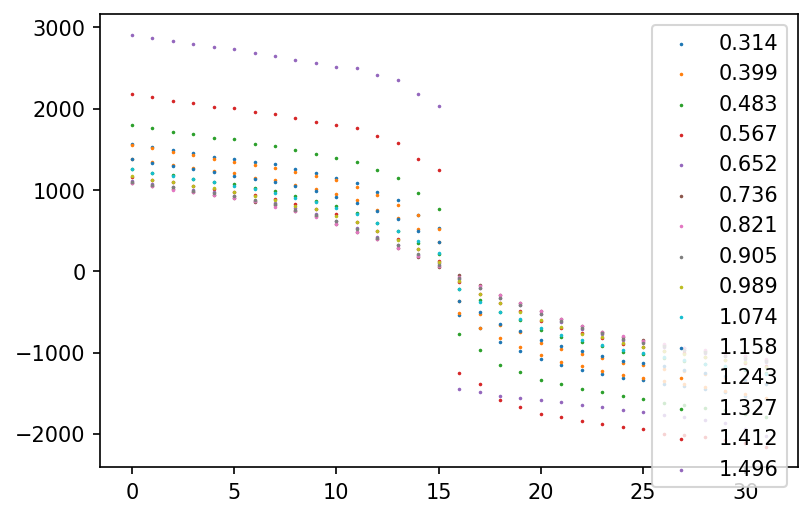

In [12]:
plt.figure(dpi = 150)
for n, i in enumerate(final_array):
    plt.scatter([i for i in range(2*strip_width)], i, s = 0.5, label = '%s' %round(theta_list[n],3))
plt.legend()

In [17]:
for i in final_array:
    print(sum(i))

-0.000688019024210007
-0.0001511513025889144
2.717240022320766e-06
-2.964895884360885e-07
2.07380890060449e-06
3.462967015366303e-07
4.4490820982900914e-07
1.2885477644886123e-06
-2.7621422304946464e-06
1.3936320783614065e-05
-9.141605778495432e-05
-0.00669116998278696
-0.12305093516738452
188.42764854122333
14211.609744414236
